# This neural network model computes the solution for the differential equation:

$$y' = sin(πx)*cos(πx), x∈[-1,1]$$ 
$$y(-1) = 0$$

**Details:**

* Layer schema: [1, 60, 60, 1]




* Activation function: Tanh

* num_domain: 2000,  num_test: 200

* Test loss for 8000 epochs: [6.76e-06, 6.32e-14]

* Train metric for 8000 epochs: [1.25e-03] 

In [ ]:
# Importing libraries

!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
import numpy as np

     |████████████████████████████████| 121 kB 15.7 MB/s 
     |████████████████████████████████| 100 kB 6.6 MB/s 


Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
# Define computational geometry

geom = dde.geometry.Interval(-1, 1)

In [ ]:
# Define the differential equation

def ode(x, y):
    dy_x = dde.grad.jacobian(y, x)
    return dy_x - tf.sin(np.pi*x)*tf.cos(np.pi*x)

In [ ]:
# Define the boundary conditions

def boundary(x, _):
    return np.isclose(x[0], -1)

bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

In [ ]:
# Define known solution

def sol(x):
  return ((np.sin(np.pi*x))**2)/(2*np.pi)

In [ ]:
# Accumulate all the data for the model

data = dde.data.PDE(geom, ode, [bc], num_domain=2000, num_boundary=2, solution=sol, num_test=200)

/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  total_n_samples))


In [ ]:
# Set the neural network schema

layer_size = [1, 60, 60, 1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
# Build and train the model

model = dde.Model(data, net)
model.compile("adam", lr=0.001,metrics=["l2 relative error"])

losshistory, train_state = model.train(epochs=8000)

/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Compiling model...
Building feed-forward neural network...
'build' took 0.065229 s

'compile' took 0.392315 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [1.34e-01, 8.77e-03]    [1.34e-01, 8.77e-03]    [1.15e+00]    
1000      [6.27e-03, 6.06e-08]    [5.89e-03, 6.06e-08]    [7.44e-02]    
2000      [5.24e-05, 1.94e-06]    [4.73e-05, 1.94e-06]    [8.60e-03]    
3000      [2.19e-05, 9.15e-07]    [1.96e-05, 9.15e-07]    [5.77e-03]    
4000      [1.10e-05, 8.90e-12]    [1.00e-05, 8.90e-12]    [1.56e-03]    
5000      [8.48e-06, 4.76e-09]    [7.88e-06, 4.76e-09]    [1.47e-03]    
6000      [7.24e-06, 9.85e-11]    [6.77e-06, 9.85e-11]    [1.32e-03]    
7000      [6.26e-06, 2.61e-12]    [5.87e-06, 2.61e-12]    [1.23e-03]    
8000      [5.46e-06, 1.10e-09]    [5.12e-06, 1.10e-09]    [1.16e-03]    

Best model at step 8000:
  train loss: 5.47e-06
  test loss: 5.12e-06
  test metric: [1.16e-03]

'train' took 49.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


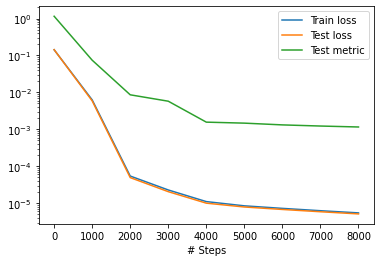

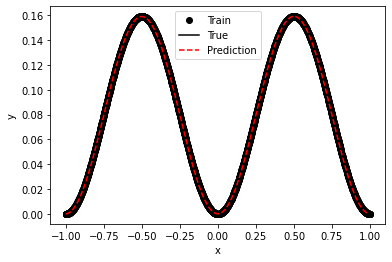

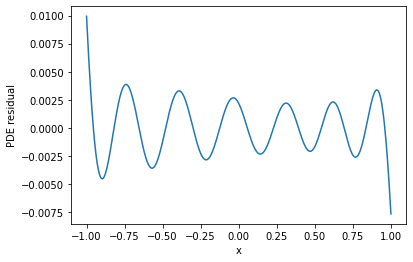

In [ ]:
# Generating plots of the results.

import matplotlib.pyplot as plt

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=ode)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()